# Final Project - Predicting Salaries for Baseball Players

## Step 1: Initial imports, exploration, and creating feature sets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
from pandas.io import sql
import sqlite3
from sklearn import neighbors,metrics,cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

In [2]:
df_batting = pd.read_csv("/Users/benstan/Documents/Python/benstan GA Data Science/Projects/baseball_data/batting.csv")
df_pitching = pd.read_csv("/Users/benstan/Documents/Python/benstan GA Data Science/Projects/baseball_data/pitching.csv")
df_fielding = pd.read_csv("/Users/benstan/Documents/Python/benstan GA Data Science/Projects/baseball_data/fielding.csv")
df_all_star = pd.read_csv("/Users/benstan/Documents/Python/benstan GA Data Science/Projects/baseball_data/all_star.csv")
df_salary = pd.read_csv("/Users/benstan/Documents/Python/benstan GA Data Science/Projects/baseball_data/salary.csv")

In [3]:
df_player = pd.read_csv("/Users/benstan/Documents/Python/benstan GA Data Science/Projects/baseball_data/player.csv")
df_player = df_player[['player_id','birth_year']]
df_player['age'] = 2015-df_player['birth_year']
del df_player['birth_year']
df_player.set_index('player_id',inplace=True)

In [4]:
batting = df_batting[df_batting['year'] == 2014].copy().reset_index()
pitching = df_pitching[df_pitching['year'] == 2014].copy().reset_index()
fielding = df_fielding[df_fielding['year'] == 2014].copy().reset_index()
all_star = df_all_star[df_all_star['year'] == 2014].copy().reset_index()
salary = df_salary[df_salary['year'] == 2015].copy().reset_index()

In [5]:
print "Batting:"
print batting.shape
print len(np.unique(batting.player_id))
fielding.replace({'pos':{'LF':'OF','RF':'OF','CF':'OF'}},inplace=True)
print "Fielding:"
print fielding.shape
print len(np.unique(fielding.player_id))
print "All star:"
print all_star.shape
print len(np.unique(all_star.player_id)) # No need for de-duping here
print "Salary:"
print salary.shape
print len(np.unique(salary.player_id)) # No need for de-duping here

Batting:
(1435, 23)
1320
Fielding:
(2487, 19)
1313
All star:
(81, 9)
81
Salary:
(817, 6)
817


In [6]:
all_star.set_index('player_id',inplace=True)
all_star['was_all_star'] = 1
for i in ['league_id','team_id','year','index','game_num','game_id','starting_pos','gp']:
    del all_star[i]
all_star.head()

,was_all_star
player_id,
cruzne02,1
hernafe02,1
perezsa02,1
cabremi01,1
canoro01,1


In [7]:
salary.set_index('player_id',inplace=True)
for i in ['league_id','team_id','year','index']:
    del salary[i]
salary.head()

,salary
player_id,
ahmedni01,508500
anderch01,512500
chafian01,507500
collmjo01,1400000
corbipa01,524000


In [8]:
conn = sqlite3.connect('batting.db', detect_types=sqlite3.PARSE_DECLTYPES)
batting.to_sql('batting',
            con=conn,
            if_exists='replace',
            index=False)

In [9]:
batting=sql.read_sql("""
SELECT
player_id,
MAX(team_id) AS team_id,
MAX(league_id) AS league_id,
SUM(g) AS g,
SUM(ab) AS ab,
SUM(r) AS r,
SUM(h) AS h,
SUM(double) AS double,
SUM(triple) AS triple,
SUM(hr) AS hr,
SUM(rbi) AS rbi,
SUM(sb) AS sb,
SUM(cs) AS cs,
SUM(bb) AS bb,
SUM(so) AS so,
SUM(ibb) AS ibb,
SUM(hbp) AS hbp,
SUM(sh) AS sh,
SUM(sf) AS sf,
SUM(g_idp) AS g_idp

FROM
batting

GROUP BY 1
""", con=conn)
batting.head()

,player_id,team_id,league_id,g,ab,r,h,double,triple,hr,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,g_idp
0,abadfe01,OAK,AL,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,abreubo01,NYN,NL,78,133,12,33,9,0,1,14,1,0,20,21,0,0,0,2,3
2,abreujo02,CHA,AL,145,556,80,176,35,2,36,107,3,1,51,131,15,11,0,4,14
3,abreuto01,SFN,NL,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,aceveal01,NYA,AL,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
conn = sqlite3.connect('fielding.db', detect_types=sqlite3.PARSE_DECLTYPES)
fielding.to_sql('fielding',
            con=conn,
            if_exists='replace',
            index=False)

In [11]:
fielding=sql.read_sql("""
SELECT
player_id,
MAX(pos) AS pos,
MAX(team_id) AS team_id,
MAX(league_id) AS league_id,
SUM(g) AS g,
SUM(gs) AS gs,
SUM(inn_outs) AS inn_outs,
SUM(po) AS po,
SUM(a) AS a,
SUM(e) AS e,
SUM(dp) AS dp

FROM
fielding

GROUP BY 1
""", con=conn)
fielding.head()

,player_id,pos,team_id,league_id,g,gs,inn_outs,po,a,e,dp
0,abadfe01,P,OAK,AL,69,None,171,0,8,0,0
1,abreubo01,OF,NYN,NL,62,None,618,74,0,4,0
2,abreujo02,1B,CHA,AL,109,None,2871,970,69,6,105
3,abreuto01,3B,SFN,NL,2,None,21,2,1,0,0
4,aceveal01,P,NYA,AL,10,None,57,2,1,0,0


In [12]:
fielding.set_index('player_id',inplace=True)
del fielding['team_id']
del fielding['league_id']
del fielding['g']
del fielding['gs']
pitching.set_index('player_id',inplace=True)
batting.set_index('player_id',inplace=True)

In [13]:
bat1 = pd.merge(batting,fielding,how='left',left_index=True,right_index=True,suffixes=('_bat','_field'))
bat2 = pd.merge(bat1,salary,how='left',left_index=True,right_index=True)
bat3 = pd.merge(bat2,all_star,how='left',left_index=True,right_index=True)
bat4 = pd.merge(bat3,df_player,how='left',left_index=True,right_index=True)

In [14]:
pos_player_df = bat4[((bat4['salary'].notnull())&(bat4['pos']!='P'))].fillna(0).copy()
del pos_player_df['team_id']
pos_player_df['in_al'] = pos_player_df['league_id'].map({'AL':1,'NL':0})
del pos_player_df['league_id']
dummies_pos = pd.get_dummies(pos_player_df['pos'],prefix='pos')
pos_player_df = pd.concat([pos_player_df,dummies_pos],axis=1)
del pos_player_df['pos']

In [15]:
pos_player_df['ba'] = pos_player_df['h'] / pos_player_df['ab']
pos_player_df['slg'] = ((pos_player_df['h']-(pos_player_df['double']+pos_player_df['triple']+pos_player_df['hr']))+
                    (2*pos_player_df['double']+3*pos_player_df['triple']+4*pos_player_df['hr'])) / pos_player_df['ab']
pos_player_df['obp'] = (pos_player_df['h']+pos_player_df['bb']+pos_player_df['hbp']) / (pos_player_df['ab']+pos_player_df['bb']+pos_player_df['hbp']+pos_player_df['sh']+pos_player_df['sf'])

In [16]:
pos_player_df.head()

,g,ab,r,h,double,triple,hr,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,g_idp,inn_outs,po,a,e,dp,salary,was_all_star,age,in_al,pos_1B,pos_2B,pos_3B,pos_C,pos_OF,pos_SS,ba,slg,obp
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
abreujo02,145,556,80,176,35,2,36,107,3,1,51,131,15,11,0,4,14,2871,970,69,6,105,8666000,1,28,1,1,0,0,0,0,0,0.316547,0.580935,0.382637
ackledu01,143,502,64,123,27,4,14,65,8,4,32,90,1,3,3,2,10,3390,490,8,4,4,2600000,0,27,1,0,0,0,0,1,0,0.245020,0.398406,0.291513
adamsma01,142,527,55,152,34,5,15,68,3,2,26,114,5,3,0,7,9,3489,1115,80,9,111,534000,0,27,0,1,0,0,0,0,0,0.288425,0.457306,0.321492
ahmedni01,25,70,9,14,2,0,1,4,0,1,3,10,0,0,2,0,2,501,27,45,2,13,508500,0,25,0,0,0,0,0,0,1,0.200000,0.271429,0.226667
alcanar01,70,278,31,57,11,2,10,29,8,5,17,93,0,2,1,2,3,1890,253,69,11,9,510000,0,24,0,0,0,0,0,1,0,0.205036,0.366906,0.253333


In [17]:
pos_player_df.describe()

,g,ab,r,h,double,triple,hr,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,g_idp,inn_outs,po,a,e,dp,salary,was_all_star,age,in_al,pos_1B,pos_2B,pos_3B,pos_C,pos_OF,pos_SS,ba,slg,obp
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,101.155941,341.039604,42.433168,89.039604,17.584158,1.839109,9.173267,40.334158,6.158416,2.279703,29.683168,72.341584,2.232673,3.433168,1.467822,2.693069,7.440594,2231.472772,339.032178,94.299505,6.155941,23.943069,4748007.361386,0.111386,29.487624,0.487624,0.066832,0.051980,0.103960,0.165842,0.410891,0.200495,0.251500,0.384575,0.310598
std,45.217401,184.327194,26.936153,52.871288,11.328847,2.291717,8.433343,27.423699,9.148331,2.847398,21.727357,41.470994,3.411457,3.534725,2.236945,2.402408,5.870728,1255.150385,292.145289,123.625011,5.006987,31.704971,5780536.586093,0.315000,3.711339,0.500467,0.250040,0.222262,0.305588,0.372400,0.492606,0.400867,0.043023,0.082477,0.047555
min,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,507500.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,66.000000,177.000000,19.000000,43.750000,8.000000,0.000000,2.750000,17.000000,0.000000,0.000000,13.000000,39.000000,0.000000,1.000000,0.000000,1.000000,3.000000,1092.750000,109.750000,10.000000,2.000000,2.000000,525000.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.231176,0.341413,0.287278
50%,110.000000,358.000000,41.000000,87.500000,16.000000,1.000000,7.000000,38.000000,3.000000,1.000000,25.500000,70.000000,1.000000,3.000000,0.000000,2.000000,6.000000,2322.000000,244.500000,33.000000,5.000000,6.000000,2050000.000000,0.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.254770,0.384615,0.313302
75%,141.000000,501.250000,62.000000,131.250000,27.000000,3.000000,13.000000,58.000000,8.000000,3.000000,43.000000,100.250000,3.000000,5.000000,2.000000,4.000000,11.000000,3369.000000,501.000000,126.250000,9.000000,36.000000,6541500.000000,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.278351,0.437625,0.338867
max,162.000000,684.000000,115.000000,225.000000,53.000000,12.000000,40.000000,116.000000,64.000000,23.000000,113.000000,190.000000,28.000000,20.000000,13.000000,11.000000,31.000000,4347.000000,1318.000000,486.000000,25.000000,130.000000,25000000.000000,1.000000,42.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.348837,0.603175,0.432000


In [18]:
pos_player_df.shape

(404, 35)

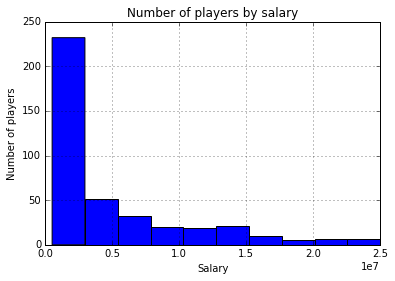

In [19]:
sal = pos_player_df['salary'].hist()
sal.set_xlabel('Salary')
sal.set_ylabel('Number of players')
sal.set_title('Number of players by salary')

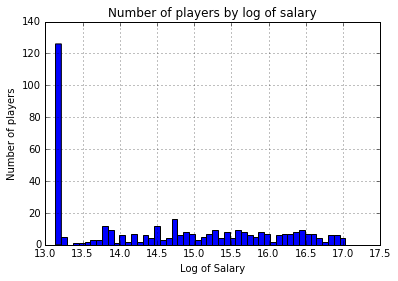

In [20]:
log_sal = np.log(pos_player_df['salary']).hist(bins=50)
log_sal.set_xlabel('Log of Salary')
log_sal.set_ylabel('Number of players')
log_sal.set_title('Number of players by log of salary')

In [21]:
pos_player_df['salary'] = np.log(pos_player_df['salary'])

## Step 2: Analyze data with linear regression

In [22]:
X = pos_player_df.copy()
del X['salary']
y = pos_player_df['salary']

In [23]:
X.shape

(404, 34)

In [24]:
def standardize(z):
    min_z = z.min()
    max_z = z.max()
    return (z-min_z)/(max_z-min_z)

In [25]:
standard_X = standardize(X)

In [26]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
linreg.score(X,y) #High R^2 value

0.69927423637655317

    Log_alphas    MSE_Ridge_CV
0          -10  2391016.149966
1           -9  2391016.145014
2           -8  2391016.095493
3           -7  2391015.600290
4           -6  2391010.648315
5           -5  2390961.134453
6           -4  2390466.583925
7           -3  2385579.309575
8           -2  2342000.249610
9           -1  2161996.531261
10           0  1697096.482625
11           1   715495.283372
12           2   522367.577036
13           3    45815.387283
14           4      670.097810
15           5        6.919561
16           6        1.525931
17           7        1.626799
18           8        1.643320
19           9        1.645037
20          10        1.645209


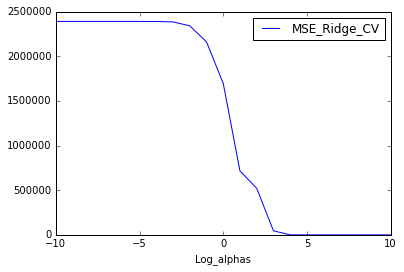

In [28]:
# Use Ridge regression to remove less significant features
kf = cross_validation.KFold(len(pos_player_df), n_folds=10, shuffle=True)
MSE_Ridge_CV = []
alphas = np.logspace(-10,10,21)
index = np.arange(-10,11)

for a in alphas:
    scores = []
    for train_index, test_index in kf:
        lm = linear_model.Ridge(alpha=a)
        lm.fit(standard_X.iloc[train_index],y.iloc[train_index])
        mse = metrics.mean_squared_error(y.iloc[test_index],lm.predict(X.iloc[test_index]))
        scores.append(mse)
    MSE_Ridge_CV.append(np.mean(scores))

MSE_Ridge_df = pd.DataFrame({'MSE_Ridge_CV':MSE_Ridge_CV,'Log_alphas':index})
print MSE_Ridge_df
MSE_Ridge_df.plot(x='Log_alphas',y='MSE_Ridge_CV')

In [29]:
lm = linear_model.Ridge(alpha=10**(5))
lm.fit(standard_X,y)
coef_df = pd.DataFrame({'coefficient':abs(lm.coef_)},index=standard_X.columns.values)
coef_df.sort_values(by='coefficient',ascending=False)

,coefficient
ab,0.000887
g,0.000859
inn_outs,0.000814
rbi,0.000787
h,0.000761
r,0.000730
double,0.000663
bb,0.000617
sf,0.000608
so,0.000557


In [30]:
mod_X = X[['ab','g','inn_outs','rbi','h','r','double','bb','sf','so','hr','g_idp','age','was_all_star']].copy()
linreg = LinearRegression()
linreg.fit(mod_X,y)
print "R^2:",linreg.score(mod_X,y) #R^2 remains high!
cv_error = cross_val_score(linreg,X,y,cv=10,scoring='mean_squared_error')
print "MSE:",np.mean(-cv_error)
#coef_df = pd.DataFrame({'feature':mod_X.columns.values,'coefficient':linreg.coef_})
#coef_df.sort_values(by='coefficient')
#metrics.mean_squared_error(y,linreg.predict(mod_X))

R^2: 0.679654577034
MSE: 0.599954457129


In [31]:
import statsmodels.formula.api as smf
# Removed features one by one using p values - Below are all tested versions of the feature set
#mod_X = X[['ab','g','inn_outs','rbi','h','r','double','bb','sf','so','hr','g_idp','age','was_all_star']].copy()
#mod_X = X[['g','inn_outs','rbi','h','r','bb','sf','so','hr','g_idp','age','was_all_star']].copy()
#mod_X = X[['g','inn_outs','rbi','h','bb','sf','so','hr','g_idp','age','was_all_star']].copy()
#mod_X = X[['g','rbi','h','bb','sf','so','hr','g_idp','age','was_all_star']].copy()
#mod_X = X[['g','rbi','h','bb','sf','so','g_idp','age','was_all_star']].copy()
mod_X = X[['g','h','bb','sf','so','g_idp','age']].copy()
lm1 = smf.ols(formula='y ~ mod_X', data=X).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     116.2
Date:                Mon, 04 Apr 2016   Prob (F-statistic):           6.46e-92
Time:                        23:14:55   Log-Likelihood:                -447.03
No. Observations:                 404   AIC:                             910.1
Df Residuals:                     396   BIC:                             942.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.9537      0.310     28.879      0.0

In [32]:
linreg = LinearRegression()
linreg.fit(mod_X,y)
print "R^2:",linreg.score(mod_X,y) #R^2 remains high!
cv_error = cross_val_score(linreg,X,y,cv=10,scoring='mean_squared_error')
print "MSE:",np.mean(-cv_error)
coef_df = pd.DataFrame({'feature':mod_X.columns.values,'coefficient':linreg.coef_})
coef_df.sort_values(by='coefficient',ascending=False)

R^2: 0.672511333661
MSE: 0.599954457129


,coefficient,feature
6,0.159684,age
3,0.042221,sf
5,0.030644,g_idp
2,0.015567,bb
1,0.011716,h
4,0.004550,so
0,-0.012155,g


Coefficients seem hard to interpret - Check for correlation between features

In [33]:
mod_X.corr()

,g,h,bb,sf,so,g_idp,age
g,1.000000,0.921564,0.763432,0.652022,0.796911,0.677839,0.233346
h,0.921564,1.000000,0.742203,0.665520,0.723594,0.717852,0.183518
bb,0.763432,0.742203,1.000000,0.567923,0.728800,0.520270,0.222034
sf,0.652022,0.665520,0.567923,1.000000,0.533495,0.538302,0.249210
so,0.796911,0.723594,0.728800,0.533495,1.000000,0.490012,0.079154
g_idp,0.677839,0.717852,0.520270,0.538302,0.490012,1.000000,0.206272
age,0.233346,0.183518,0.222034,0.249210,0.079154,0.206272,1.000000


All features aside from age highly correlated - Pick age and another feature to make prediction

In [34]:
mod_X = X[['bb','age']].copy()
linreg = LinearRegression()
linreg.fit(mod_X,y)
print "R^2:",linreg.score(mod_X,y) #R^2 remains high!
cv_error = cross_val_score(linreg,X,y,cv=10,scoring='mean_squared_error')
print "MSE:",np.mean(-cv_error)
coef_df = pd.DataFrame({'feature':mod_X.columns.values,'coefficient':linreg.coef_})
coef_df.sort_values(by='coefficient',ascending=False)

R^2: 0.585652743617
MSE: 0.599954457129


,coefficient,feature
1,0.156773,age
0,0.030814,bb


R^2 and MSE remain high - Age is strong predictor for salary!

## Step 3: Analyze data with decision trees

    cv_scores  depth
0    1.122427      1
1    0.879346      2
2    0.822964      3
3    0.866596      4
4    0.851300      5
5    0.925439      6
6    0.982190      7
7    0.977132      8
8    0.980295      9
9    1.016792     10
10   1.002372     11
11   0.951437     12
12   0.996381     13
13   0.978475     14
14   1.037026     15
15   1.019679     16
16   1.015475     17
17   1.016248     18
18   1.003291     19


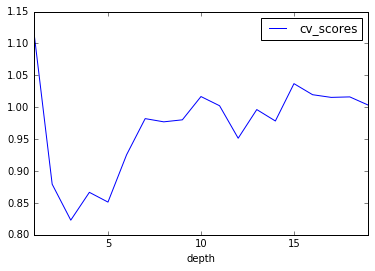

In [35]:
depth_range = range(1,20)
cv_scores = []
for i in depth_range:
    treereg = DecisionTreeRegressor(max_depth=i)
    cv_error = cross_val_score(treereg,X,y,cv=10,scoring='mean_squared_error')
    cv_scores.append(np.mean(np.sqrt(-cv_error)))

depth_df = pd.DataFrame({'depth':depth_range,'cv_scores':cv_scores})
print depth_df
depth_df.plot(x='depth',y='cv_scores')

Depth of three performs best

In [36]:
treereg = DecisionTreeRegressor(max_depth=3)
cv_error = cross_val_score(treereg,X,y,cv=10,scoring='mean_squared_error')
np.mean(-cv_error)

0.69432518396371468

## Step 3: Analyze data with random forest

   num_features  oob_scores
0             1    0.495675
1             6    0.621706
2            11    0.651153
3            16    0.662586
4            21    0.659269
5            26    0.658016


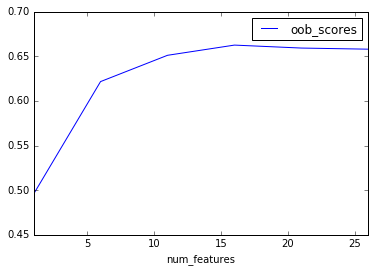

In [37]:
num_features = range(1,30,5)
oob_score_RF = []
for i in num_features:
    rf = RandomForestRegressor(n_estimators=1000,max_features=i,min_samples_leaf=5,oob_score=True)
    rf.fit(X,y)
    oob_score_RF.append(rf.oob_score_)

oob_score_df = pd.DataFrame({'num_features':num_features,'oob_scores':oob_score_RF})
print oob_score_df
oob_score_df.plot(x='num_features',y='oob_scores')

   num_features  oob_scores
0             1    0.494053
1             2    0.543158
2             3    0.570120
3             4    0.590313
4             5    0.608871
5             6    0.623225
6             7    0.629943
7             8    0.639492
8             9    0.645592


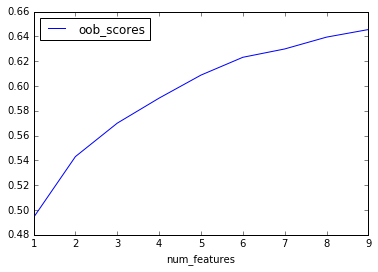

In [38]:
# Zoom in further to select best number of features
num_features = range(1,10)
oob_score_RF = []
for i in num_features:
    rf = RandomForestRegressor(n_estimators=1000,max_features=i,min_samples_leaf=5,oob_score=True)
    rf.fit(X,y)
    oob_score_RF.append(rf.oob_score_)

oob_score_df = pd.DataFrame({'num_features':num_features,'oob_scores':oob_score_RF})
print oob_score_df
oob_score_df.plot(x='num_features',y='oob_scores')

Six features to use at random per node performs best

   num_trees  oob_scores
0        100    0.610252
1        500    0.624953
2       1000    0.620678
3       5000    0.620512
4      10000    0.621132


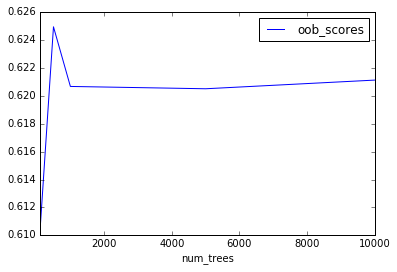

In [39]:
num_trees = [100,500,1000,5000,10000]
oob_score_RF = []
for i in num_trees:
    rf = RandomForestRegressor(n_estimators=i,max_features=6,min_samples_leaf=5,oob_score=True)
    rf.fit(X,y)
    oob_score_RF.append(rf.oob_score_)
    
oob_score_df = pd.DataFrame({'num_trees':num_trees,'oob_scores':oob_score_RF})
print oob_score_df
oob_score_df.plot(x='num_trees',y='oob_scores')

500 or 1000 estimators performs best - Varies based on run

   num_samples  oob_scores
0            1    0.634992
1            2    0.630685
2            3    0.632977
3            4    0.628516
4            5    0.616884
5            6    0.615106
6            7    0.614872
7            8    0.606488
8            9    0.603981
9           10    0.600953


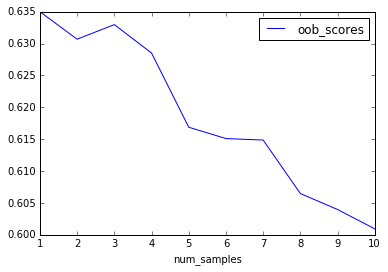

In [40]:
num_samples = range(1,11)
oob_score_RF = []
for i in num_samples:
    rf = RandomForestRegressor(n_estimators=1000,max_features=6,min_samples_leaf=i,oob_score=True)
    rf.fit(X,y)
    oob_score_RF.append(rf.oob_score_)
    
oob_score_df = pd.DataFrame({'num_samples':num_samples,'oob_scores':oob_score_RF})
print oob_score_df
oob_score_df.plot(x='num_samples',y='oob_scores')

One sample minimum at terminal node performs best

In [41]:
RF = RandomForestRegressor(n_estimators = 1000, 
                       max_features = 6,     
                       min_samples_leaf = 1,
                       oob_score = True) 
cv_error = cross_val_score(RF, X, y, cv=10, scoring='mean_squared_error')
np.mean(-cv_error)

0.60369069152501731

In [42]:
RF.fit(X,y)
feature_importances_df = pd.DataFrame({'feature':X.columns.values,'importance':RF.feature_importances_})
feature_importances_df.sort_values(by='importance',ascending=False)[:10]

,feature,importance
23,age,0.147871
10,bb,0.097865
7,rbi,0.087521
1,ab,0.073589
4,double,0.071643
3,h,0.069977
2,r,0.050175
0,g,0.043082
16,g_idp,0.029170
17,inn_outs,0.028636


## Step 4: Analyze data with boosted trees

   CV_Error  Max_Depth
0  0.758991          1
1  0.788282          2
2  0.778196          3
3  0.772409          4


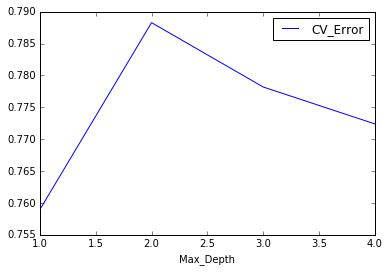

In [43]:
depth = range(1,5)
scores = []
for i in depth:
    GBR_Tree = GradientBoostingRegressor(learning_rate = 0.01, # This is lambda, a tuning parameter, usually between 0.01 and 0.1
                                            n_estimators = 10000, #This is B, a tuning parameter, using large B can cause overfitting
                                            max_depth = i, #This is d, another tuning parameter, usually max_depth < 5
                                            min_samples_leaf = 5  )  
    cv_error = cross_val_score(GBR_Tree,X,y,cv=10,scoring='mean_squared_error')
    scores.append(np.mean(np.sqrt(-cv_error)))

depth_choice_df = pd.DataFrame({'CV_Error': scores,'Max_Depth': depth})
print depth_choice_df
depth_choice_df.plot(x ='Max_Depth', y = 'CV_Error')

Depth of 1 is best

In [44]:
NumberOfTrees = [100,1000,5000,10000,20000]
learning_rate = [0.01,0.03,0.05,0.07,0.09,.1]
tree_col = []
rate_col = []
scores = []
for i in NumberOfTrees:
    for j in learning_rate:
        GBR_Tree = GradientBoostingRegressor(learning_rate = j, # This is lambda, a tuning parameter, usually between 0.01 and 0.1
                                            n_estimators = i, #This is B, a tuning parameter, using large B can cause overfitting
                                            max_depth = 1, #This is d, another tuning parameter, usually max_depth < 5
                                            min_samples_leaf = 5  )  
        cv_error = cross_val_score(GBR_Tree,X,y,cv=10,scoring='mean_squared_error')
        tree_col.append(i)
        rate_col.append(j)
        scores.append(np.mean(np.sqrt(-cv_error)))

In [45]:
tuning_df = pd.DataFrame({'num_trees': tree_col,'learning_rate':rate_col,'CV_Error': scores})
#print tuning_df.sort_values(by=['learning_rate','num_trees'])
print tuning_df.sort_values(by='CV_Error')

    CV_Error  learning_rate  num_trees
5   0.738747           0.10        100
6   0.739554           0.01       1000
4   0.741475           0.09        100
7   0.743416           0.03       1000
3   0.747099           0.07        100
12  0.747443           0.01       5000
8   0.748530           0.05       1000
9   0.753157           0.07       1000
10  0.758357           0.09       1000
18  0.758924           0.01      10000
11  0.761394           0.10       1000
2   0.764762           0.05        100
13  0.772775           0.03       5000
24  0.786592           0.01      20000
14  0.800099           0.05       5000
19  0.809671           0.03      10000
1   0.820699           0.03        100
15  0.820896           0.07       5000
16  0.838898           0.09       5000
20  0.845828           0.05      10000
17  0.848057           0.10       5000
25  0.859662           0.03      20000
21  0.874231           0.07      10000
22  0.895328           0.09      10000
26  0.901786           0.

0.1 learning rate and 100 estimator trees appears to minimize the error

In [46]:
GBR_Tree = GradientBoostingRegressor(learning_rate = 0.1, # This is lambda, a tuning parameter, usually between 0.01 and 0.1
                                     n_estimators = 100, #This is B, a tuning parameter, using large B can cause overfitting
                                     max_depth = 1, #This is d, another tuning parameter, usually max_depth < 5
                                     min_samples_leaf = 5)
scores = cross_val_score(GBR_Tree,X,y,cv=10,scoring='mean_squared_error')
print (np.mean(-scores))

0.558620716401


In [47]:
GBR_Tree.fit(X,y)
gbr_feature_importances_df = pd.DataFrame({'feature':X.columns.values,'importance':GBR_Tree.feature_importances_})
gbr_feature_importances_df.sort_values(by='importance',ascending=False)[:10]

,feature,importance
23,age,0.26
14,sh,0.10
3,h,0.10
19,a,0.09
10,bb,0.09
7,rbi,0.06
1,ab,0.06
16,g_idp,0.06
18,po,0.05
11,so,0.03


## Step 5: Use alternative method with principal components

In [48]:
def demean(z):
    return z-z.mean()

[ 0.95452404  0.9925678   0.996361    0.99906024  0.99942511  0.99957434
  0.99968256  0.99978034  0.99985448  0.99990975  0.99993722  0.99995379
  0.99996331  0.99997047  0.99997673  0.99998233  0.9999869   0.99999073
  0.99999378  0.99999567  0.99999721  0.99999853  0.99999961  0.99999974
  0.99999982  0.99999989  0.99999992  0.99999995  0.99999998  1.          1.
  1.          1.          1.        ]


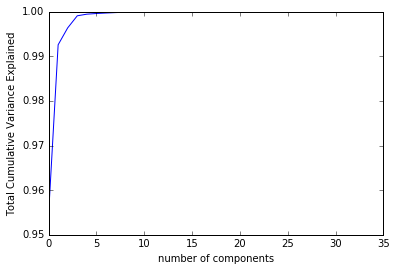

In [49]:
var_explained_by_comp = PCA().fit(demean(X)).explained_variance_ratio_
print np.cumsum(var_explained_by_comp)
plt.plot(np.cumsum(var_explained_by_comp))
plt.xlabel('number of components')
plt.ylabel('Total Cumulative Variance Explained')

Two principle components capture over 99% of variance

In [50]:
clf = PCA(4)
X_trans = clf.fit_transform(demean(X))
X_trans.shape

(404, 4)

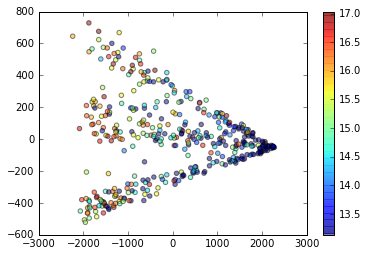

In [51]:
plt.scatter(X_trans[:, 0], X_trans[:, 1],c=y, alpha=0.5)
plt.colorbar();

### Use PCA output with KNN regressor

      error  num_neighbors
0  1.398729              1
1  1.230990              2
2  1.175772              3
3  1.133421              4
4  1.114415              5
5  1.091145              6
6  1.086360              7
7  1.085125              8
8  1.079201              9


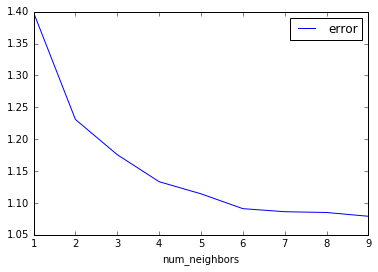

In [52]:
num_neighbors = range(1,10)
errors = []
for i in num_neighbors:
    knn = neighbors.KNeighborsRegressor(n_neighbors=i,weights='uniform')
    knn.fit(X_trans,y)
    mse = cross_val_score(knn,X_trans,y,cv=10,scoring='mean_squared_error')
    errors.append(np.mean(np.sqrt(-mse)))

error_df = pd.DataFrame({'num_neighbors':num_neighbors,'error':errors})
print error_df
error_df.plot(x='num_neighbors',y='error')

Seven neighbors leads to best performance

In [53]:
knn = neighbors.KNeighborsRegressor(n_neighbors=7,weights='uniform')
knn.fit(X_trans,y)
mse = cross_val_score(knn,X_trans,y,cv=10,scoring='mean_squared_error')
np.mean(-mse)

1.1924010004637686

### Use PCA output with decision trees

    cv_scores  depth
0    1.158185      1
1    1.131426      2
2    1.109765      3
3    1.079380      4
4    1.079068      5
5    1.136418      6
6    1.197975      7
7    1.245972      8
8    1.290328      9
9    1.292185     10
10   1.326419     11
11   1.322265     12
12   1.353150     13
13   1.381488     14
14   1.374439     15
15   1.351294     16
16   1.367457     17
17   1.370097     18
18   1.337175     19


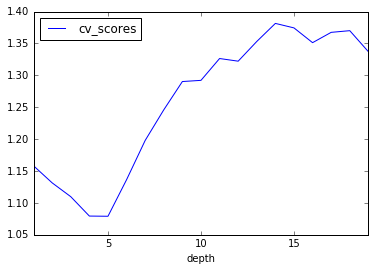

In [54]:
depth_range = range(1,20)
cv_scores = []
for i in depth_range:
    treereg = DecisionTreeRegressor(max_depth=i)
    cv_error = cross_val_score(treereg,X_trans,y,cv=10,scoring='mean_squared_error')
    cv_scores.append(np.mean(np.sqrt(-cv_error)))

depth_df = pd.DataFrame({'depth':depth_range,'cv_scores':cv_scores})
print depth_df
depth_df.plot(x='depth',y='cv_scores')

In [55]:
treereg = DecisionTreeRegressor(max_depth=5)
mse = cross_val_score(treereg,X_trans,y,cv=10,scoring='mean_squared_error')
np.mean(-mse)

1.1918969171474063